In this notebook, we'll be tackling the following problem: given two data sets, how do we find which points are less than some distance apart?

The end goal of this is to use a data structure called kD tree, but we'll explore some other concepts along the way.

Let's start by creating two datasets in 2D, defined in the $[-1,1]$ interval in both axes.

In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [31]:
data_1 = 200*np.random.random((10000,2)) - 100
data_2 = 200*np.random.random((10000,2)) - 100

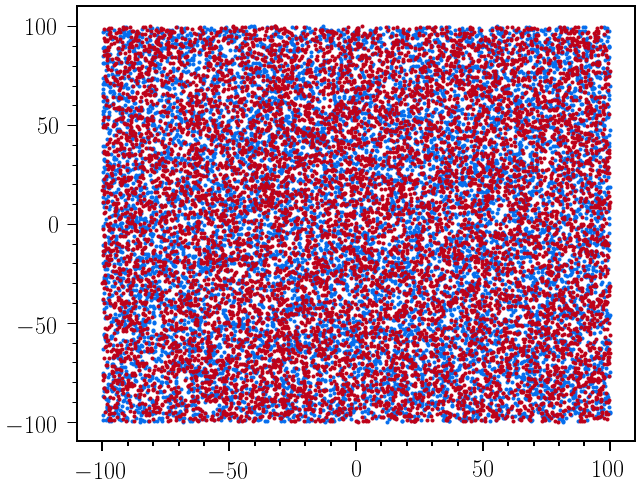

In [32]:
pl.plot(data_1[:,0], data_1[:,1], '.')
pl.plot(data_2[:,0], data_2[:,1], '.')

pl.show()

We wish to find all points in `data_2` that are within distance 1 of points in `data_1`. Let's do the naive implementation first:

In [94]:
%%time
where = []
for i in range(10000):
    point = data_1[i]
    dist = np.sqrt((data_2[:,0] - point[0])**2 + (data_2[:,1] - point[1])**2)
    wh = np.where(dist < 1)[0]
    if len(wh) > 0:
        for j in wh:
            where.append((i,j))

CPU times: user 601 ms, sys: 0 ns, total: 601 ms
Wall time: 600 ms


The array `where` has the tuples $(i,j)$ of all the points $i$ in `data_1` that are within distance 1 of points $j$ in `data_2`. 

In [34]:
where

[(1, 8464),
 (2, 4350),
 (3, 8697),
 (3, 9232),
 (4, 5163),
 (6, 1952),
 (6, 5079),
 (6, 7295),
 (6, 7299),
 (7, 2850),
 (8, 3437),
 (9, 7893),
 (9, 9824),
 (11, 7562),
 (17, 6012),
 (17, 6766),
 (18, 918),
 (19, 6202),
 (21, 7457),
 (21, 7890),
 (21, 9583),
 (23, 7125),
 (23, 7157),
 (24, 2238),
 (24, 4136),
 (27, 5956),
 (30, 6640),
 (30, 8339),
 (30, 8594),
 (31, 6444),
 (31, 8857),
 (32, 6107),
 (35, 3047),
 (36, 457),
 (36, 7917),
 (37, 219),
 (45, 4032),
 (47, 7324),
 (48, 8686),
 (49, 6502),
 (53, 4364),
 (54, 5427),
 (57, 8267),
 (58, 8583),
 (58, 9594),
 (60, 761),
 (61, 716),
 (62, 718),
 (62, 2470),
 (62, 7917),
 (62, 8526),
 (66, 7352),
 (68, 2856),
 (69, 5669),
 (71, 5427),
 (74, 2002),
 (75, 8174),
 (75, 9862),
 (76, 6041),
 (79, 4893),
 (81, 5602),
 (82, 8992),
 (84, 2795),
 (91, 5954),
 (94, 6136),
 (95, 9740),
 (97, 7429),
 (98, 8164),
 (99, 8977),
 (100, 7326),
 (102, 1468),
 (102, 6666),
 (104, 2290),
 (106, 1613),
 (106, 4766),
 (106, 6106),
 (106, 9022),
 (107, 131

Let's try to make this faster using kD trees. This is a k-dimensional tree structure that is built for such problems!

In [41]:
from scipy.spatial import KDTree

In [42]:
tree_1 = KDTree(data_1)

In [43]:
%%time
res = tree_1.query_ball_point(data_2,1)


CPU times: user 6.2 s, sys: 155 µs, total: 6.2 s
Wall time: 6.19 s


The `res` array has a similar structure: index $j$ tells me the indices of points in `data_1` that are within distance 1 of point $j$ in `data_2`.

In [45]:
res

array([list([]), list([]), list([1052, 4638, 9070]), ..., list([]),
       list([]), list([7539])], dtype=object)

Wait, that's actually slower... How can we make this faster? Trees can do tree-on-tree searches, so let's make a tree with `data_2`!

In [44]:
tree_2 = KDTree(data_2)

In [46]:
%%time
res = tree_1.query_ball_tree(tree_2,1)


CPU times: user 2.29 s, sys: 19 µs, total: 2.29 s
Wall time: 2.29 s


3x faster than the previous one, but still slower than pure numpy...

There's a trick: the `KDTree` class is, under-the-hood, written in pure Python. Scipy also provides a `cKDTree` class that is written in C instead:

In [47]:
from scipy.spatial import cKDTree
tree_1 = cKDTree(data_1)

In [48]:
%%time
res = tree_1.query_ball_point(data_2,1)


CPU times: user 25.1 ms, sys: 20 µs, total: 25.1 ms
Wall time: 24.2 ms


A lot faster, faster than pure Python!

In [49]:
tree_2 = cKDTree(data_2)

In [50]:
%%time
res = tree_1.query_ball_tree(tree_2,1)


CPU times: user 9.97 ms, sys: 0 ns, total: 9.97 ms
Wall time: 9.31 ms


Almost 6x faster than the numpy implementation.

Let's try the numpy implementation in `numba`:

In [89]:
import numba
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",cache = True)
def search_data(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in range(10000):
        point = data_1[i]
        for j in range(10000):
            target = data_2[j]
            dist[i,j] = np.sqrt((target[0] - point[0])**2 + (target[1] - point[1])**2)
    return dist


The first time we run it, it'll be slow, as it's compiling the function.

In [92]:
%%time
search_data(data_1, data_2)

CPU times: user 432 ms, sys: 169 ms, total: 601 ms
Wall time: 599 ms


array([[135.93027537,  61.43642964, 135.28095513, ...,  33.99663099,
        131.40914003,  48.21889859],
       [156.05149421,  75.91548743, 143.33023733, ...,  71.43074221,
        112.0958967 ,  85.64855038],
       [100.91179179, 121.1460955 , 145.45625143, ..., 108.70616392,
        216.41994764,  90.6185704 ],
       ...,
       [ 94.96585266, 137.33333041,  63.97379446, ..., 205.73247909,
        126.34673759, 196.81570447],
       [100.00300647,  99.89647436,  50.20931491, ..., 170.76014077,
         64.93831105, 166.72720961],
       [ 66.70167878, 114.99380661,  41.32548062, ..., 181.13007159,
        123.40622006, 171.13016656]])

Second time is a bit faster, as it's already compiled:

In [93]:
%%time
search_data(data_1, data_2)

CPU times: user 474 ms, sys: 141 ms, total: 615 ms
Wall time: 612 ms


array([[135.93027537,  61.43642964, 135.28095513, ...,  33.99663099,
        131.40914003,  48.21889859],
       [156.05149421,  75.91548743, 143.33023733, ...,  71.43074221,
        112.0958967 ,  85.64855038],
       [100.91179179, 121.1460955 , 145.45625143, ..., 108.70616392,
        216.41994764,  90.6185704 ],
       ...,
       [ 94.96585266, 137.33333041,  63.97379446, ..., 205.73247909,
        126.34673759, 196.81570447],
       [100.00300647,  99.89647436,  50.20931491, ..., 170.76014077,
         64.93831105, 166.72720961],
       [ 66.70167878, 114.99380661,  41.32548062, ..., 181.13007159,
        123.40622006, 171.13016656]])

Still slower than the cKD tree! But note that this computes the distance only, and you need to do `np.where(dist[dist < 1])` to get the results.

Now let's try compiling a parallel version of this function:

In [104]:
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",parallel=True, cache=True)
def search_data_parallel(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in numba.prange(10000):
        point = data_1[i]
        for j in numba.prange(10000):
            target = data_2[j]
            dist[i,j] = np.sqrt((target[0] - point[0])**2 + (target[1] - point[1])**2)
    return dist


%%time
search_data_parallel(data_1, data_2)

In [109]:
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",parallel=True, cache=True)
def search_data_vectorized(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in numba.prange(10000):
        point = data_1[i]
        dist[i] = np.sqrt((data_2[:,0] - point[0])**2 + (data_2[:,1] - point[1])**2)
    return dist


In [ ]:
%%time
search_data_vectorized(data_1, data_2)

As fast as the non-vectorized version!